# Spatial mapping of cell types across the mouse brain (1/3) - estimating reference expression signatures of cell types

This notebook demonstrates how to use the **cell2location** model for mapping a single cell reference cell types onto a spatial transcriptomic dataset. Here, we use a 10X single nucleus RNA-sequencing (snRNAseq) and Visium spatial transcriptomic data generated from adjacent tissue sections of the mouse brain ([Kleshchevnikov et al., BioRxiv 2020](https://www.biorxiv.org/content/10.1101/2020.11.15.378125v1)). 

Cell2location is a Bayesian model that integrates single-cell RNA-seq (scRNA-seq) and
multi-cell spatial transcriptomics to efficiently map large and comprehensive cell type references (Fig 1). 

![Figure 1.](../images/Fig1_v2.png)  
***Figure 1.*** *Overview of the spatial mapping approach and the workflow which are enabled by cell2location. From left to right: Single-cell RNA-seq and spatial transcriptomics profiles are generated from the same tissue (1). Cell2location takes reference cell type signatures derived from scRNA-seq and spatial transcriptomics data as input (2, 3). The model then decomposes spatially resolved multi-cell RNA counts matrices into the reference signatures, thereby establishing a spatial mapping of cell types (4).*

In the first step covered by this notebook (#2 in Fig 1), we estimate reference cell type signatures from scRNA-seq profiles, for example as obtained using conventional clustering to identify cell types and subpopulations followed by estimation of average cluster gene expression profiles ([Suppl. Methods, Section 2](https://github.com/vitkl/cell2location_paper/blob/master/paper/Supplementary_Methods_cell2location.pdf), [Fig S1](https://github.com/vitkl/cell2location_paper/blob/master/paper/FigS1_cell2location_workflow.pdf)). Cell2location implements this estimation step based on Negative Binomial regression, which allows to robustly combine data across technologies and batches ([Suppl. Methods, Section 2](https://github.com/vitkl/cell2location_paper/blob/master/paper/Supplementary_Methods_cell2location.pdf)).

## Outline

The [**cell2location** workflow](https://github.com/vitkl/cell2location_paper/blob/master/paper/FigS1_cell2location_workflow.pdf) consists of three sections:

I. Estimating reference expression signatures of cell types (1/3, this notebook):

1. [Loading single cell reference data](#1.-Loading-single-cell-reference-data)
2. [Reduce the number of genes by discarding lowly expressed genes](#2.-Reduce-the-number-of-genes-by-discarding-lowly-expressed-genes)
3. [Exploring the data: show UMAP of cells](#3.-Show-UMAP-of-cells)
4. [Estimating expression signatures](#4.-Estimating-expression-signatures)
5. [Additional quality control: removing technical effects and performing standard scanpy single cell analysis workflow](#5.-Additional-quality-control:-removing-technical-effects-and-performing-standard-scanpy-single-cell-analysis-workflow)

II. Spatially mapping cell types (2/3)

III. Results and downstream analysis (3/3)


## Loading packages

First, we need to load the relevant packages. Regression model for estimating expression signatures of cell types cell2location is written in pytorch. While the package works on both GPU and CPU, using the GPU shortens the computation time by ~8 times to just a few minutes.

In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os

data_type = 'float32'

import cell2location

import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Loading single cell reference data <a name="1.-Loading-single-cell-reference-data"></a>

In this tutorial, we use a paired Visium and snRNAseq reference dataset of the mouse brain (i.e. generated from adjacent tissue sections). This datasets consists of cells coming from 3 sections from 2 mice each. We have annotated 59 cell neuronal and glial populations across multiple brain regions, including 10 subtypes of regional astrocytes.

First we need to load the data from our data portal:

In [2]:
sc_data_folder = '/nfs/team205/vk7/sanger_projects/large_data/gut_kj_re/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/gut/'

Now, we load the pre-processed snRNAseq reference. Scanpy website has tutorials covering how to import other formats.

In [3]:
## snRNA reference (raw counts)
adata_snrna_raw = anndata.read_h5ad(sc_data_folder + "FINAL_OBJECT_raw_nosoupx.h5ad")

consolidated_annot = sc_data_folder + "for_vitalii_combined_2.csv"
consolidated_annot = pd.read_csv(consolidated_annot, index_col=0)

In [4]:
consolidated_annot = consolidated_annot.loc[consolidated_annot['combined'] != 'doublet', :]
consolidated_annot

,sample,Sample name,Diagnosis,Age,sample name,Region code,Fraction,Region,10X,V2.0,batch,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,doublet_scores,predicted_doublets,Age_group,combined
AAACCTGAGCATCATC-1-Human_colon_16S8159182,Human_colon_16S8159182,F72,fetal,16Wk,F72-FPIL-0-SC-1,FPIL,SC,SmallInt,5',included,Human_colon_16S8159182,2761,2761,10270.3870,270.027040,2.629181,0.018905,False,Second trim,Enterocyte
AAACCTGAGCGATCCC-1-Human_colon_16S8159182,Human_colon_16S8159182,F72,fetal,16Wk,F72-FPIL-0-SC-1,FPIL,SC,SmallInt,5',included,Human_colon_16S8159182,4088,4088,25394.4790,1153.138800,4.540904,0.049027,False,Second trim,Enterocyte
AAACCTGAGCGTTTAC-1-Human_colon_16S8159182,Human_colon_16S8159182,F72,fetal,16Wk,F72-FPIL-0-SC-1,FPIL,SC,SmallInt,5',included,Human_colon_16S8159182,1128,1128,2416.9785,200.108120,8.279267,0.011701,False,Second trim,Enterocyte
AAACCTGAGGATGTAT-1-Human_colon_16S8159182,Human_colon_16S8159182,F72,fetal,16Wk,F72-FPIL-0-SC-1,FPIL,SC,SmallInt,5',included,Human_colon_16S8159182,874,874,1890.5691,83.922585,4.439012,0.015436,False,Second trim,LTi-like NK/T
AAACCTGCAAATTGCC-1-Human_colon_16S8159182,Human_colon_16S8159182,F72,fetal,16Wk,F72-FPIL-0-SC-1,FPIL,SC,SmallInt,5',included,Human_colon_16S8159182,1436,1436,2765.6165,273.796020,9.900000,0.086141,False,Second trim,Arterial ECs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTACATGTC-1-4918STDY7718977,4918STDY7718977,BRC2134,fetal,10Wk,NaN,FLI,SC-EPCAMP,LargeInt,3',included,4918STDY7718977,718,718,1256.7183,53.416590,4.250483,0.027844,False,First trim,Enterocyte
TTTGTCATCCAAGCCG-1-4918STDY7718977,4918STDY7718977,BRC2134,fetal,10Wk,NaN,FLI,SC-EPCAMP,LargeInt,3',included,4918STDY7718977,2012,2012,6319.1733,96.362030,1.524915,0.070144,False,First trim,Mesoderm 1 (HAND1+)
TTTGTCATCCATGCTC-1-4918STDY7718977,4918STDY7718977,BRC2134,fetal,10Wk,NaN,FLI,SC-EPCAMP,LargeInt,3',included,4918STDY7718977,1502,1502,3346.7026,42.566097,1.271882,0.034341,False,First trim,Mesoderm 2 (ZEB2+)
TTTGTCATCCCAAGTA-1-4918STDY7718977,4918STDY7718977,BRC2134,fetal,10Wk,NaN,FLI,SC-EPCAMP,LargeInt,3',included,4918STDY7718977,2191,2191,6743.4077,93.216385,1.382333,0.055641,False,First trim,Mesoderm 1 (HAND1+)


In [5]:
ind = np.intersect1d(adata_snrna_raw.obs_names, consolidated_annot.index)
consolidated_annot = consolidated_annot.loc[ind,:]
adata_snrna_raw = adata_snrna_raw[ind,:]
adata_snrna_raw.obs = consolidated_annot.loc[adata_snrna_raw.obs_names,:]

In [6]:
adata_snrna_raw.layers, adata_snrna_raw.raw

(Layers with keys: , None)

In [7]:
(adata_snrna_raw.obs.head(), 1)

(                                                           sample Sample name  \
 AAACCTGAGAAACCTA-1-Human_colon_16S8159188  Human_colon_16S8159188         F73   
 AAACCTGAGAACAACT-1-FCA_gut9456313                  FCA_gut9456313     BRC2258   
 AAACCTGAGAAGAAGC-1-4918STDY7693757                4918STDY7693757     BRC2121   
 AAACCTGAGAAGAAGC-1-FCA_gut9456319                  FCA_gut9456319     BRC2258   
 AAACCTGAGAAGCCCA-1-4918STDY7718974                4918STDY7718974     BRC2134   
 
                                           Diagnosis     Age  \
 AAACCTGAGAAACCTA-1-Human_colon_16S8159188     fetal    15Wk   
 AAACCTGAGAACAACT-1-FCA_gut9456313             fetal  11.1Wk   
 AAACCTGAGAAGAAGC-1-4918STDY7693757            fetal   9.2Wk   
 AAACCTGAGAAGAAGC-1-FCA_gut9456319             fetal  11.1Wk   
 AAACCTGAGAAGCCCA-1-4918STDY7718974            fetal    10Wk   
 
                                                  sample name Region code  \
 AAACCTGAGAAACCTA-1-Human_colon_16S8159188 

In [8]:
# remove first trimester samples
first_trimester = [
"FCA_gut9456326",
"4918STDY7321513",
"4918STDY7321514",
"4918STDY7321515",
"4918STDY7317585",
"4918STDY7317586",
"4918STDY7317587",
"4918STDY7421297",
"4918STDY7421298",
"4918STDY7421299",
"4918STDY7426904",
"4918STDY7426905",
"4918STDY7426906",
"4918STDY7426907",
"4918STDY7426908",
"4918STDY7426909",
"4918STDY7693757",
"4918STDY7693758",
"4918STDY7693759",
"4918STDY7693760",
"4918STDY7693761",
"4918STDY7693762",
"4918STDY7693763",
"4918STDY7717783",
"4918STDY7717784",
"4918STDY7717785",
"4918STDY7717787",
"4918STDY7717788",
"4918STDY7717789",
"4918STDY7718972",
"4918STDY7718973",
"4918STDY7718974",
"4918STDY7718975",
"4918STDY7718976",
"4918STDY7718977",
                  
"Human_colon_16S8159186",
"FCA_gut8015061"]

adata_snrna_raw = adata_snrna_raw[~adata_snrna_raw.obs['sample'].isin(first_trimester), :]

In [9]:
# checking that data is integer counts
adata_snrna_raw.X.data

array([ 1.,  3.,  1., ...,  9.,  5., 16.], dtype=float32)

## 2. Reduce the number of genes by discarding lowly expressed genes <a name="2.-Reduce-the-number-of-genes-by-discarding-lowly-expressed-genes"></a>

This is performed using 2 cut-off to remove as many lowly expressed genes as possible and yet avoid highly variable gene selection (HVG) which is prone to deleting markers of rare populations:

1. Include all genes expressed by at least 3% of cells (`cell_count_cutoff2`)
2. Include genes expressed by at least 0.02% of cells (`cell_count_cutoff`) when they have high counts in non-zero cells (`nonz_mean_cutoff`)

We prefer this way of selecting genes because step 2 allows retaining genes expressed by rare cell populations but at high levels, whereas standard HVG selection methods can filter out such genes due to their low global mean and variance.

Trying to set attribute `.obs` of view, copying.


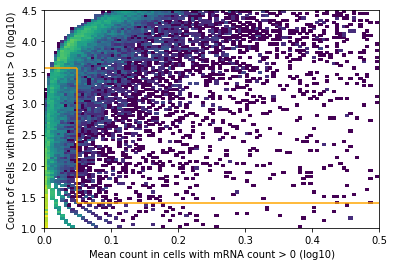

In [10]:
# remove cells and genes with 0 counts everywhere
sc.pp.filter_cells(adata_snrna_raw, min_genes=1)
sc.pp.filter_genes(adata_snrna_raw, min_cells=1)

# calculate the mean of each gene across non-zero cells
adata_snrna_raw.var['n_cells'] = np.array((adata_snrna_raw.X > 0).sum(0)).flatten()
adata_snrna_raw.var['nonz_mean'] = np.array(adata_snrna_raw.X.sum(0)).flatten() \
/ adata_snrna_raw.var['n_cells']

plt.hist2d(np.log10(adata_snrna_raw.var['nonz_mean']),
           np.log10(adata_snrna_raw.var['n_cells']), bins=100,
           norm=mpl.colors.LogNorm(),
           range=[[0,0.5], [1,4.5]]);

nonz_mean_cutoff = np.log10(1.12) # cut off for expression in non-zero cells 
cell_count_cutoff = np.log10(adata_snrna_raw.shape[0] * 0.0002) # cut off percentage for cells with higher expression
cell_count_cutoff2 = np.log10(adata_snrna_raw.shape[0] * 0.03)# cut off percentage for cells with small expression

plt.vlines(nonz_mean_cutoff, cell_count_cutoff, cell_count_cutoff2, color = 'orange');
plt.hlines(cell_count_cutoff, nonz_mean_cutoff, 1, color = 'orange');
plt.hlines(cell_count_cutoff2, 0, nonz_mean_cutoff, color = 'orange');
plt.xlabel('Mean count in cells with mRNA count > 0 (log10)');
plt.ylabel('Count of cells with mRNA count > 0 (log10)');

Show the number of selected cells and genes:

In [11]:
adata_snrna_raw[:,(np.array(np.log10(adata_snrna_raw.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff)].shape

(124060, 13904)

Filter the object:

In [12]:
# select genes based on mean expression in non-zero cells
adata_snrna_raw = adata_snrna_raw[:,(np.array(np.log10(adata_snrna_raw.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff)]

Add counts matrix as `adata.raw` 

In [13]:
adata_snrna_raw.var['SYMBOL'] = adata_snrna_raw.var_names
adata_snrna_raw.var_names = adata_snrna_raw.var['gene_ids']
adata_snrna_raw.var_names.name = None

Trying to set attribute `.var` of view, copying.


In [14]:
adata_snrna_raw.raw = adata_snrna_raw

## 3. Show UMAP of cells <a name="3.-Show-UMAP-of-cells"></a>

We can examine the cell composition of our data by using a standard scanpy workflow to generate a UMAP representation of the single cell data.

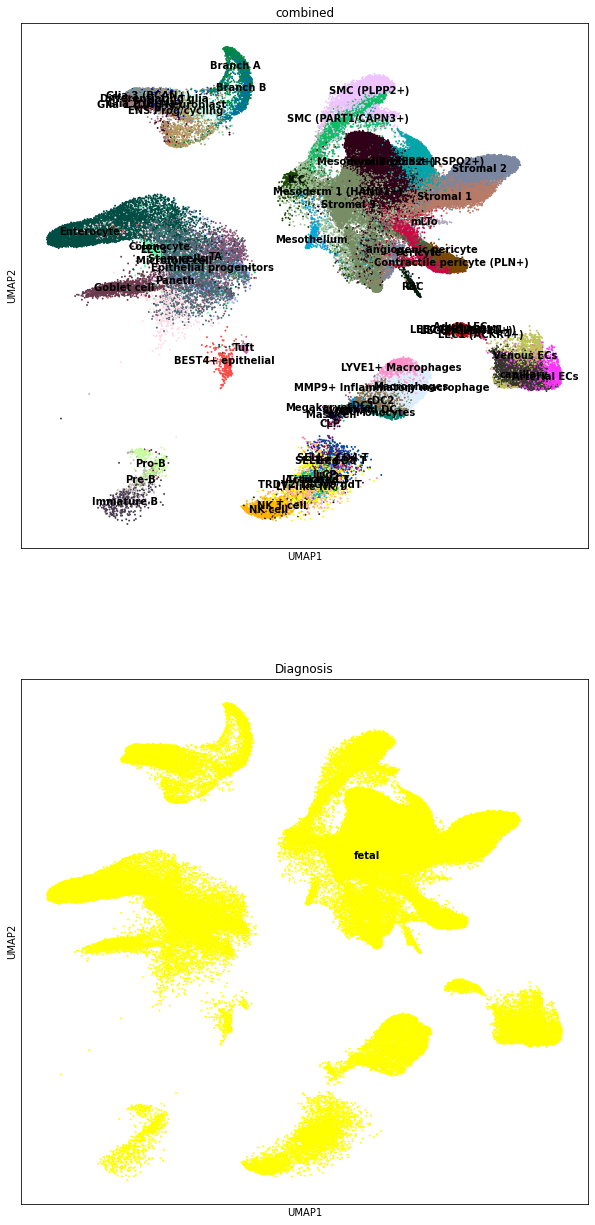

In [16]:
with mpl.rc_context({'figure.figsize': [10, 10],
                     'axes.facecolor': 'white'}):
    sc.pl.umap(adata_snrna_raw, color=['combined', 'Diagnosis'], size=15,
               #color_map = 'RdPu', 
               ncols = 1, legend_loc='on data',
               palette=sc.pl.palettes.default_102,
               legend_fontsize=10)

In [ ]:
adata_snrna_raw.obs['combined']

## 4. Estimating expression signatures  <a name="4.-Estimating-expression-signatures"></a> 

### Brief description of the model

**Model-based estimation of reference expression signatures of cell types $g_{f,g}$ using a regularised Negative Binomial regression.** This model robustly derives reference expression signatures of cell types $g_{f,g}$ using the data composed of multiple batches $e=\{1..E\}$ and technologies $t=\{1..T\}$. Adapting the assumptions of a range of computational methods for scRNA-seq, we assume that the expression count matrix follows a Negative Binomial distribution with unobserved expression levels (rates) $\mu_{c,g}$ and a gene-specific over-dispersion $\alpha_g$. We model $\mu_{c,g}$ as a linear function of reference cell type signatures and technical effects:
- $e_e$ denotes a multiplicative global scaling parameter between experiments/batches $e$ (e.g. differences in sequencing depth);
- $t_{t,g}$ accounts for multiplicative gene-specific difference in sensitivity between technologies; 
- $b_{e,g}$ accounts for additive background shift of each gene in each experiment $e$ (proxy for free-floating RNA).


![Model diagram](../images/Regression_model_diagram.png)  

Also see https://cell2location.readthedocs.io/en/latest/cell2location.regression_models.html#regressiongenebackgroundcoveragegenetechnologytorch

```python
help(cell2location.models.RegressionGeneBackgroundCoverageTorch)
```

### Training the model

Here we show how to perform the training of this model wrapped into a singe pipeline function call, how to assess the quality of this model and extract reference signatures of cell types for use with cell2location:

In [17]:
fetal = adata_snrna_raw[adata_snrna_raw.obs['Diagnosis'] == 'fetal',:]
fetal.obs['combined'].value_counts(), adata_snrna_raw.obs['combined'].value_counts()

(Mesoderm 2 (ZEB2+)               20612
 Stromal 3                        15573
 Enterocyte                       11434
 Stromal 2                         9180
 Stromal 1                         9056
                                  ...  
 LEC5 (CLDN11+)                      23
 Megakaryocyte                       17
 Lymphoid DC                          9
 Adult LEC                            7
 MMP9+ Inflammatory macrophage        4
 Name: combined, Length: 67, dtype: int64,
 Mesoderm 2 (ZEB2+)               20612
 Stromal 3                        15573
 Enterocyte                       11434
 Stromal 2                         9180
 Stromal 1                         9056
                                  ...  
 LEC5 (CLDN11+)                      23
 Megakaryocyte                       17
 Lymphoid DC                          9
 Adult LEC                            7
 MMP9+ Inflammatory macrophage        4
 Name: combined, Length: 67, dtype: int64)

In [18]:
ct_sel = fetal.obs['combined'].value_counts()
ct_sel = ct_sel.index[ct_sel > 8]
fetal = fetal[fetal.obs['combined'].isin(ct_sel),:]

### Creating model ### - time 0.12 min
### Analysis name: RegressionGeneBackgroundCoverageGeneTechnologyTorch_88covariates_124049cells_13904genes_noLN_revise
### Training model to determine n_epochs with CV ###


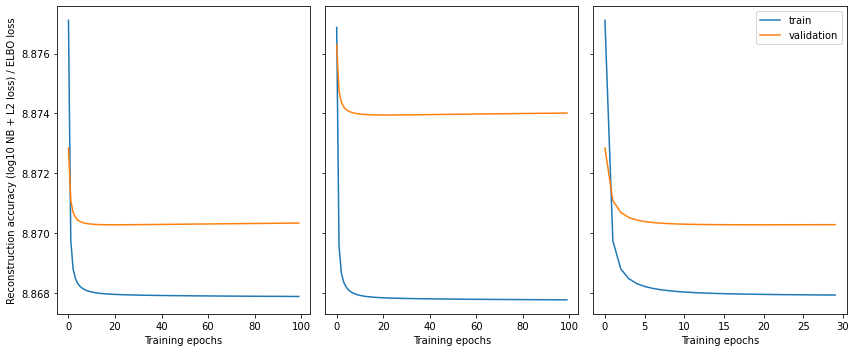

### Re-training model to stop before overfitting ###


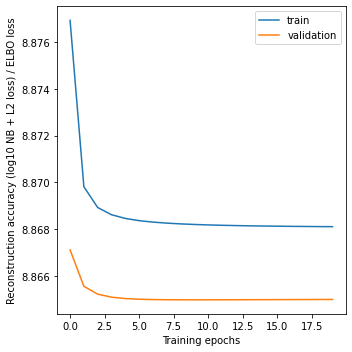

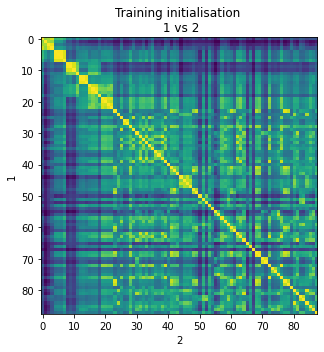

### Evaluating parameters / sampling posterior ### - time 41.06 min


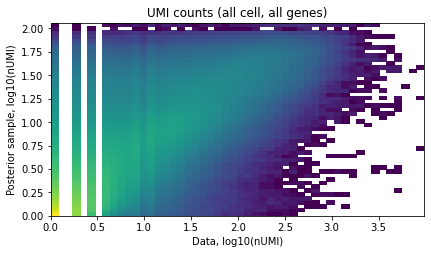

### Saving results ###
### Plotting results ###


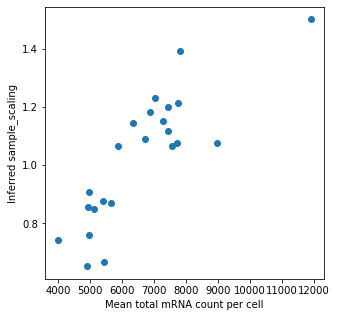

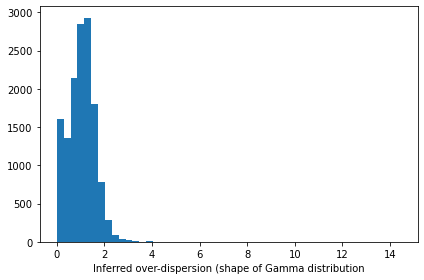

### Done ### - time 44.68 min


In [19]:
# Run the pipeline:
from cell2location import run_regression
r, adata_snrna_raw = run_regression(fetal, # input data object]
                   
                   verbose=True, return_all=True,
                                 
                   train_args={
                    'covariate_col_names': ['combined'], # column listing cell type annotation
                    'sample_name_col': 'sample', # column listing sample ID for each cell
                    
                    # column listing technology, e.g. 3' vs 5', 
                    # when integrating multiple single cell technologies corresponding 
                    # model is automatically selected
                    'tech_name_col': '10X', 
                    
                    'stratify_cv': 'combined', # stratify cross-validation by cell type annotation
                       
                    'n_epochs': 100, 'minibatch_size': 1024, 'learning_rate': 0.01, 'n_restarts': 2,
                       
                    'use_cuda': True, # use GPU?
                       
                    'train_proportion': 0.97, # proportion of cells in the training set (for cross-validation)
                    'l2_weight': True,  # True = use defaults for the model
                    
                    'readable_var_name_col': 'SYMBOL', 'use_raw': True},
                                 
                   model_kwargs={}, # keep defaults
                   posterior_args={}, # keep defaults
                                 
                   export_args={'path': results_folder + 'regression_model/', # where to save results
                                'save_model': True, # save pytorch model?
                                'run_name_suffix': '_noLN_revise'})

reg_mod = r['mod']

In [20]:
adata_snrna_raw.obs['Diagnosis'].value_counts()

fetal    124049
Name: Diagnosis, dtype: int64

Saved anndata object and the trained model object can be read later using:
    
```python

```

In [21]:
reg_mod_name = 'RegressionGeneBackgroundCoverageGeneTechnologyTorch_88covariates_124049cells_13904genes_noLN_revise'
reg_path = f'{results_folder}regression_model/{reg_mod_name}/'

## snRNAseq reference (raw counts)
adata_snrna_raw = sc.read(f'{reg_path}sc.h5ad')
## model
import pickle
r = pickle.load(file = open(f'{reg_path}model_.p', "rb"))
reg_mod = r['mod']

Export reference expression signatures of cell types:

In [22]:
# Export cell type expression signatures:
covariate_col_names = 'combined'

inf_aver = adata_snrna_raw.raw.var.copy()
inf_aver = inf_aver.loc[:, [f'means_cov_effect_{covariate_col_names}_{i}' for i in adata_snrna_raw.obs[covariate_col_names].unique()]]
from re import sub
inf_aver.columns = [sub(f'means_cov_effect_{covariate_col_names}_{i}', '', i) for i in adata_snrna_raw.obs[covariate_col_names].unique()]
inf_aver = inf_aver.iloc[:, inf_aver.columns.argsort()]

# scale up by average sample scaling factor
inf_aver = inf_aver * adata_snrna_raw.uns['regression_mod']['post_sample_means']['sample_scaling'].mean()

Compare estimated signatures (y-axis) to analytically computed mean expression (x-axis):

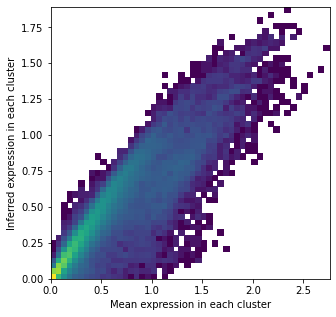

In [23]:
# compute mean expression of each gene in each cluster
aver = cell2location.cluster_averages.cluster_averages.get_cluster_averages(adata_snrna_raw, covariate_col_names)
aver = aver.loc[adata_snrna_raw.var_names, inf_aver.columns]

# compare estimated signatures (y-axis) to analytically computed mean expression (x-axis)
with mpl.rc_context({'figure.figsize': [5, 5]}):
    plt.hist2d(np.log10(aver.values.flatten()+1), np.log10(inf_aver.values.flatten()+1),
               bins=50, norm=mpl.colors.LogNorm());
    plt.xlabel('Mean expression in each cluster');
    plt.ylabel('Inferred expression in each cluster');

Evaluate whether estimated signatures are less correlated because the confounding sample background is now removed:

Mesoderm 1 (HAND1+)              683.095209
Pre-B                            826.080479
LEC1 (ACKR4+)                   1014.090767
pDC                             1476.347331
NK cell                         1479.191945
Activated T                     1642.153740
LTi-like NK/T                   1663.581511
Tuft                            1680.189601
Treg                            1723.248328
Mesoderm 2 (ZEB2+)              1804.365782
Stromal 1                       1808.169363
TRDV2/TRGV9 gdT                 1951.343511
Immature B                      1959.891766
Mast cell                       2005.391301
LTi-like ILC3                   2041.518379
RBC                             2066.637557
LYVE1+ Macrophages              2087.237561
ILCP                            2111.883739
ICC                             2116.975878
Neuroblast                      2157.335863
Pro-B                           2254.234162
Glia 2 (ELN+)                   2307.099100
myofibroblast (RSPO2+)          

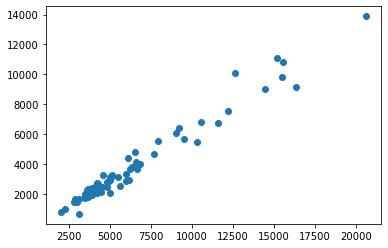

In [24]:
plt.scatter(aver.sum(), inf_aver.sum())

pd.set_option('display.max_rows', len(aver.sum()))
inf_aver.sum().sort_values()

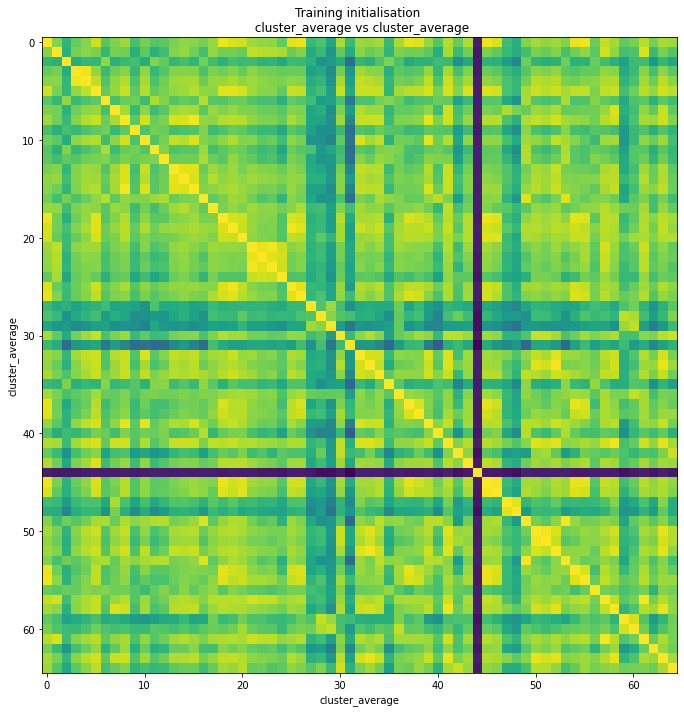

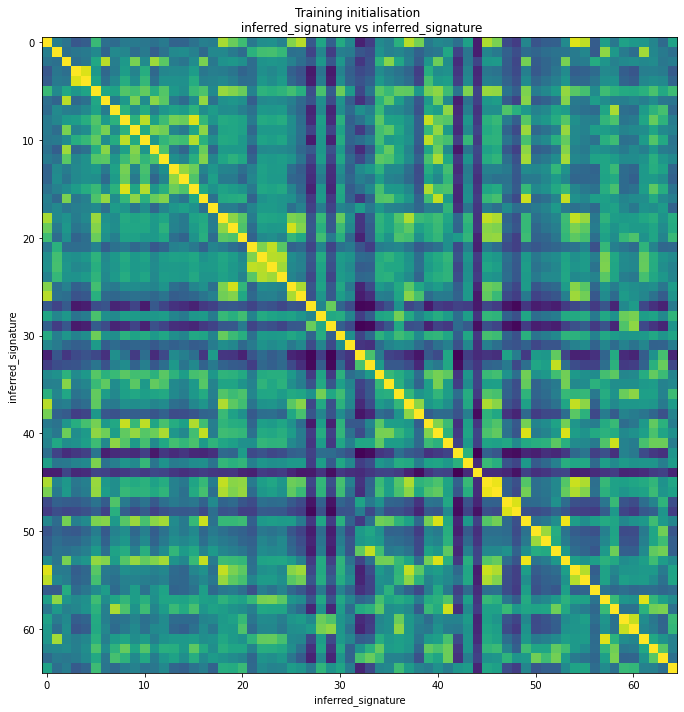

In [25]:
# Look at how correlated are the signatures obtained by computing mean expression
with mpl.rc_context({'figure.figsize': [10, 10]}):
    reg_mod.align_plot_stability(aver, aver, 'cluster_average', 'cluster_average', align=False)
    plt.show()

# Look at how correlated are the signatures inferred by regression model - they should be less correlated than above
with mpl.rc_context({'figure.figsize': [10, 10]}):
    reg_mod.align_plot_stability(inf_aver, inf_aver, 'inferred_signature', 'inferred_signature', align=False)
    plt.show()

Compare cell count per experiment to estimated background (soup, free-floating RNA):

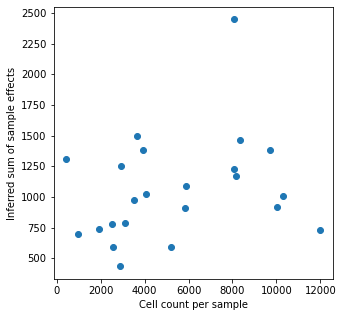

In [26]:
# Examine how many mRNA per cell on average are background 
sample_name_col = 'sample'
cell_count = adata_snrna_raw.obs[sample_name_col].value_counts()
cell_count.index = [f'means_sample_effect{sample_name_col}_{i}' for i in cell_count.index] 
soup_amount = reg_mod.sample_effects.sum(0) 

with mpl.rc_context({'figure.figsize': [5, 5]}):
    plt.scatter(cell_count[soup_amount.index].values.flatten(),
                soup_amount.values.flatten());
    plt.xlabel('Cell count per sample'); # fraction of reads in cells
    plt.ylabel('Inferred sum of sample effects');

Supply reference expression signatures to cell2location model (see next notebook):

```python
# Use `inf_aver` for cell2location mapping:
cell2location.run_cell2location(sc_data=inf_aver, ...)
```

## 5. Additional quality control: removing technical effects and performing standard scanpy single cell analysis workflow <a name="5.-Additional-quality-control:-removing-technical-effects-and-performing-standard-scanpy-single-cell-analysis-workflow"></a>

This allows to identify if the model successfully accounted for technical factor by checking whether removing contribution those factors from every single cell leads to merging of samples / batches, yet preserves well-separated cell types in the UMAP space.

In [27]:
adata_snrna_raw_cor = adata_snrna_raw.copy()
#del adata_snrna_raw_cor.uns['log1p']

adata_snrna_raw_cor.X = np.array(reg_mod.normalise(adata_snrna_raw_cor.raw.X.copy()))

sc.pp.log1p(adata_snrna_raw_cor)
sc.pp.scale(adata_snrna_raw_cor, max_value=10)
sc.tl.pca(adata_snrna_raw_cor, svd_solver='arpack', n_comps=80, use_highly_variable=False)

adata_snrna_raw.obs['total_counts'] = np.array(adata_snrna_raw.raw.X.sum(1)).flatten()
adata_snrna_raw_cor.obs['total_counts'] = adata_snrna_raw.obs['total_counts']

#sc.pl.pca(adata_snrna_raw_cor, color=['total_counts'],
#          components=['0,1', '2,3', '4,5', '6,7', '8,9', '10,11', '12,13'],
#          color_map = 'RdPu', ncols = 3, legend_loc='on data', vmax='p99.9',
#          legend_fontsize=10)

# remove the first PC which explains large amount of variance in total UMI count (likely technical variation)
adata_snrna_raw_cor.obsm['X_pca'] = adata_snrna_raw_cor.obsm['X_pca'][:, 1:]
adata_snrna_raw_cor.varm['PCs'] = adata_snrna_raw_cor.varm['PCs'][:, 1:]

# here we use standard neighbors function rather than bbknn 
# to show that the regression model can merge batches / experiments
sc.pp.neighbors(adata_snrna_raw_cor, n_neighbors = 15, n_pcs = 79, metric='cosine')
sc.tl.umap(adata_snrna_raw_cor, min_dist = 0.2, spread = 1)

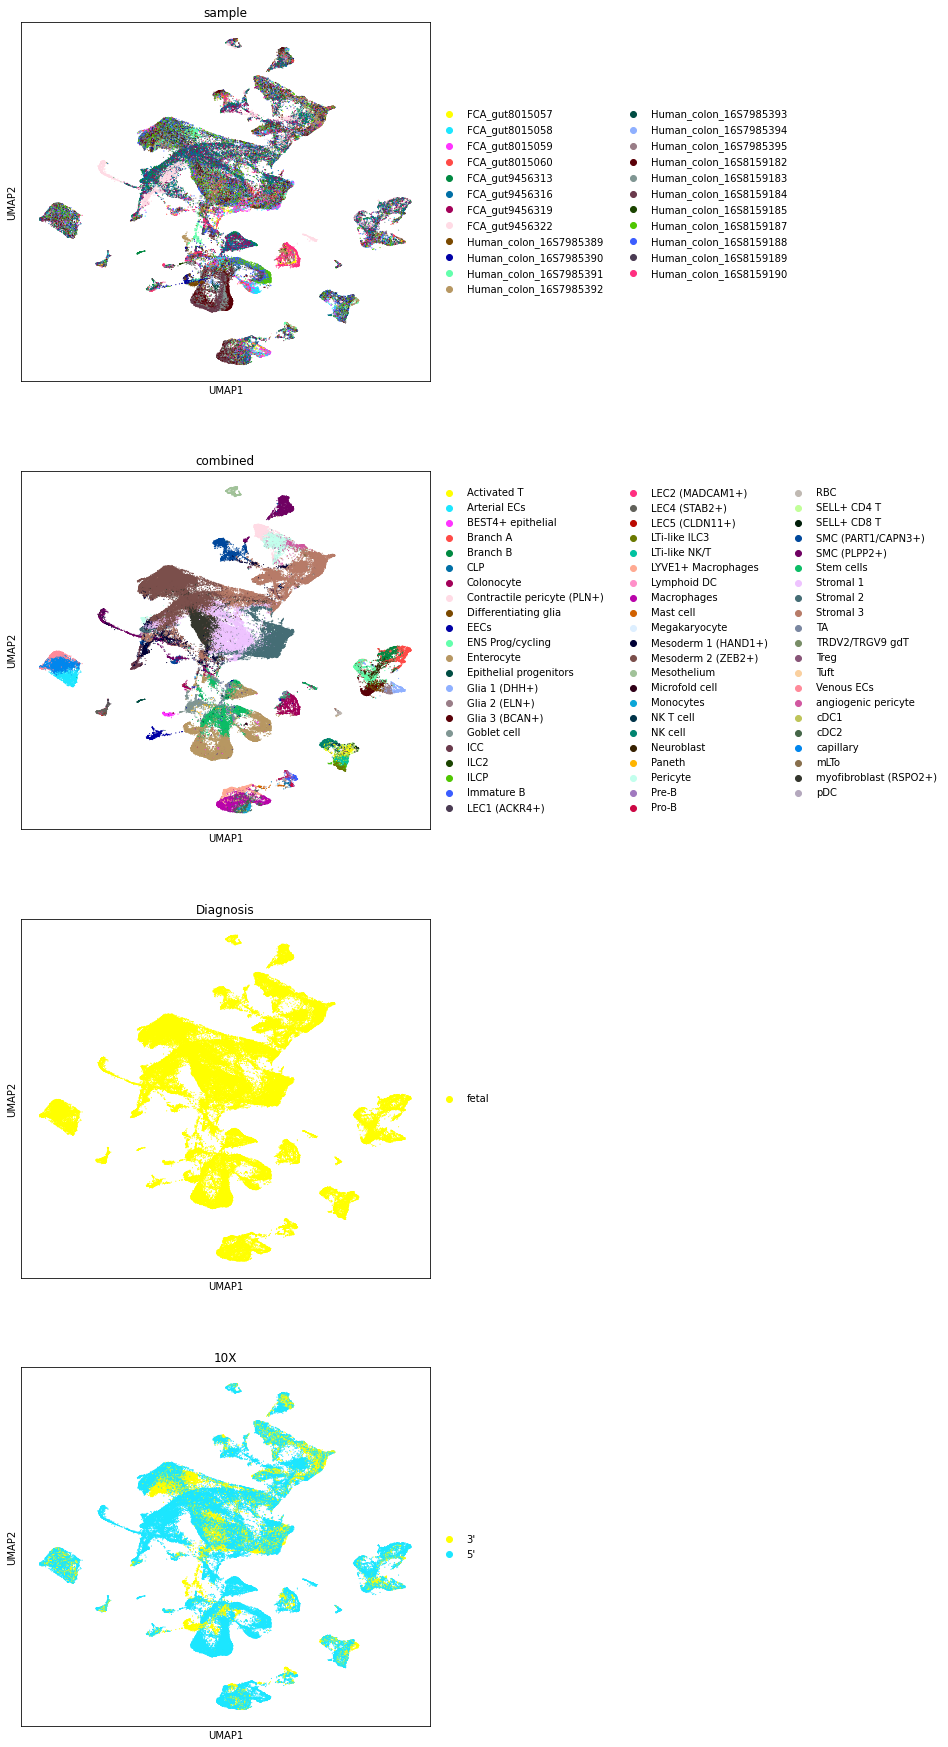

In [29]:
with mpl.rc_context({'figure.figsize': [7, 7],
                     'axes.facecolor': 'white'}):
    
    fig_path = f'{results_folder}plots/figures/'
    sc_figpath = sc.settings.figdir
    sc.settings.figdir = f'{fig_path}'

    sc.pl.umap(adata_snrna_raw_cor, color=["sample", 'combined', 'Diagnosis', '10X'],
               color_map = 'RdPu', ncols = 1, size=5, #legend_loc='on data',
               legend_fontsize=10, palette=sc.pl.palettes.default_102,
               save='regression_umap.pdf')

Modules and their versions used for this analysis

In [30]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(sys.modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass

sys 3.7.8 | packaged by conda-forge | (default, Nov 17 2020, 23:45:15) 
[GCC 7.5.0]
ipykernel 5.3.4
ipykernel._version 5.3.4
json 2.0.9
re 2.2.1
IPython 7.19.0
IPython.core.release 7.19.0
logging 0.5.1.2
zlib 1.0
traitlets 5.0.5
traitlets._version 5.0.5
argparse 1.1
ipython_genutils 0.2.0
ipython_genutils._version 0.2.0
platform 1.0.8
IPython.core.crashhandler 7.19.0
pygments 2.7.2
pexpect 4.8.0
ptyprocess 0.6.0
decorator 4.4.2
pickleshare 0.7.5
backcall 0.2.0
sqlite3 2.6.0
sqlite3.dbapi2 2.6.0
_sqlite3 2.6.0
prompt_toolkit 3.0.8
wcwidth 0.2.5
jedi 0.17.2
parso 0.7.1
colorama 0.4.4
ctypes 1.1.0
_ctypes 1.1.0
urllib.request 3.7
jupyter_client 6.1.7
jupyter_client._version 6.1.7
zmq 20.0.0
zmq.backend.cython 40303
zmq.backend.cython.constants 40303
zmq.sugar 20.0.0
zmq.sugar.constants 40303
zmq.sugar.version 20.0.0
jupyter_core 4.7.0
jupyter_core.version 4.7.0
tornado 6.1
_curses b'2.2'
dateutil 2.8.1
dateutil._version 2.8.1
six 1.15.0
decimal 1.70
_decimal 1.70
distutils 3.7.8
scanpy 1.